In [12]:
import sys, os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../..')
from src import raw_data_path, direcslist, load_image, ImageQuant2
%matplotlib widget

### Data paths

In [13]:
basepath = raw_data_path + '/Imaging/mlc4'
paths = direcslist(basepath, 1)

### Extract data from paths

In [14]:
dates = []
lines = []
embryo_ids = []
for p in paths:
    code = p.strip('/').split('/')[-2]
    dates.append(code.split('_')[0])
    lines.append(code.split('_')[1])
    embryo_ids.append(int(str(os.path.getctime(glob.glob(p + '/*488 SP 535-50*')[0])).replace('.', '')))
df = pd.DataFrame({'Path': paths, 'EmbryoID': embryo_ids, 'Line': lines, 'Date': dates})
df = df[df.Line.isin(['lp637', 'nwg240', 'nwg338', 'nwg376'])]
df['Path'] = df['Path'].apply(lambda x: x[len(raw_data_path):])
df.to_csv('../../data/mlc4_embryos.csv')
df

,Path,EmbryoID,Line,Date
0,/Imaging/mlc4/220504_nwg376_2205031400mlc4_tom...,16739714415749032,nwg376,220504
1,/Imaging/mlc4/220504_nwg376_2205031400mlc4_tom...,16739714426025324,nwg376,220504
2,/Imaging/mlc4/220504_nwg376_2205031400mlc4_tom...,1673971441272869,nwg376,220504
3,/Imaging/mlc4/220504_nwg376_2205031400mlc4_tom...,16739714404844115,nwg376,220504
4,/Imaging/mlc4/220504_nwg376_2205031400mlc4_tom...,16739714407744381,nwg376,220504
5,/Imaging/mlc4/220505_lp637_2205041200mlc4_tom4...,16739714470053463,lp637,220505
6,/Imaging/mlc4/220505_lp637_2205041200mlc4_tom4...,16739714475341754,lp637,220505
7,/Imaging/mlc4/220505_lp637_2205041200mlc4_tom4...,16739714454042032,lp637,220505
8,/Imaging/mlc4/220505_lp637_2205041200mlc4_tom4...,16739714431879508,lp637,220505
9,/Imaging/mlc4/220505_lp637_2205041200mlc4_tom4...,16739714437929206,lp637,220505


### Segment

In [15]:
# results = []
# for index, row in df.iterrows():
#     print(row.Path)
    
#     # Import movie
#     img = load_image(row.Path + '/af_corrected.tif')
#     roi = np.loadtxt(row.Path + '/ROI_fit_anaphase.txt')
    
#     # Run quantification
#     iq = ImageQuant2(img=img, roi=roi)
#     iq.segment()
    
#     # Save ROIs
#     for i, r in enumerate(iq.roi):
#         np.savetxt(row.Path + '/ROI_fit_%s.txt' % i, r)

### Import quantification model

In [16]:
membg = np.loadtxt('../../data/calibration_mem6.txt')
cytbg = np.loadtxt('../../data/calibration_cyt.txt')
calibration_factor = np.loadtxt('../../data/calibration_constants.txt')[6]
print(calibration_factor)

3.128136976235888


### Loop through embryos and quantify

100%|██████████| 1000/1000 [00:12<00:00, 83.13it/s]
/Users/blandt/anaconda3/anaconda3/envs/par2_paper/lib/python3.7/site-packages/discco/discco.py:561: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
100%|██████████| 1000/1000 [00:07<00:00, 128.90it/s]


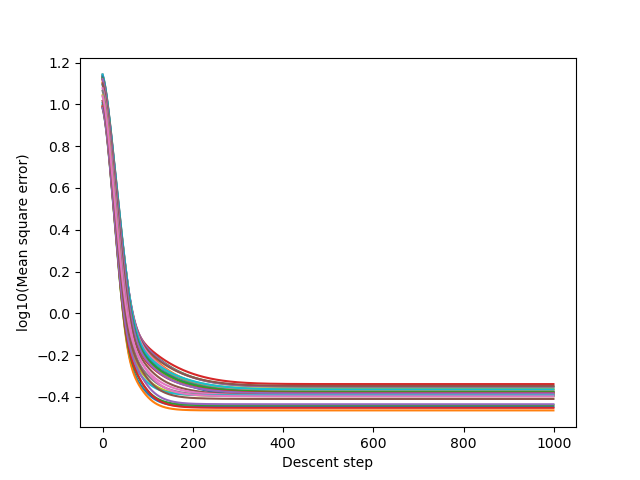

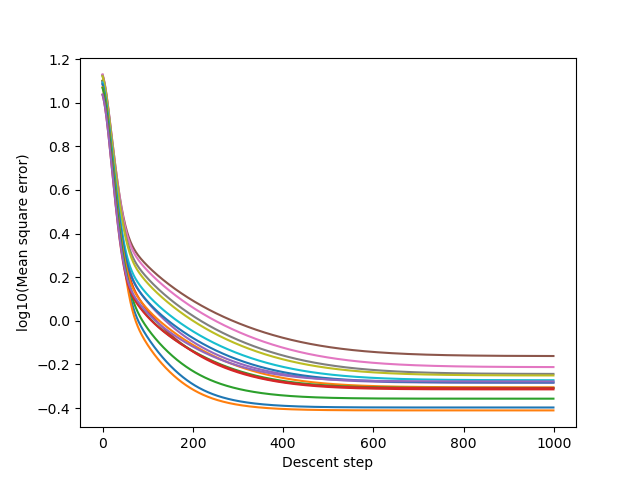

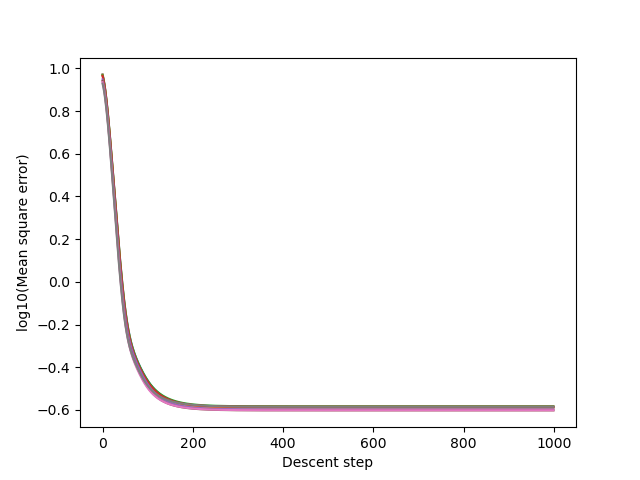

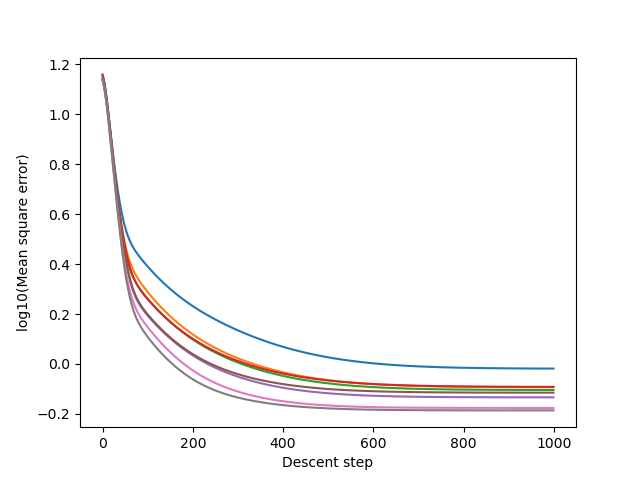

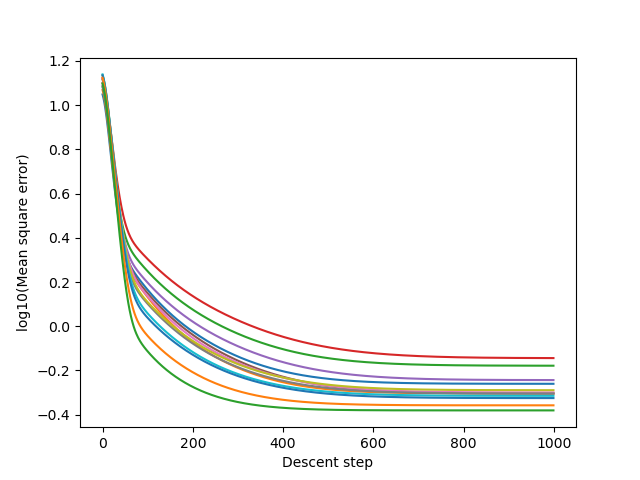

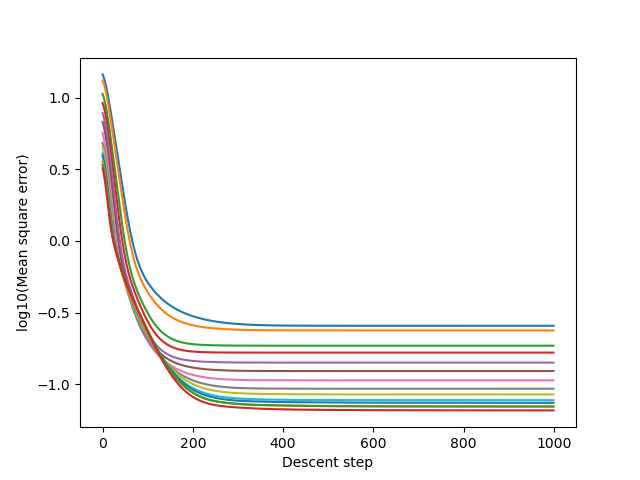

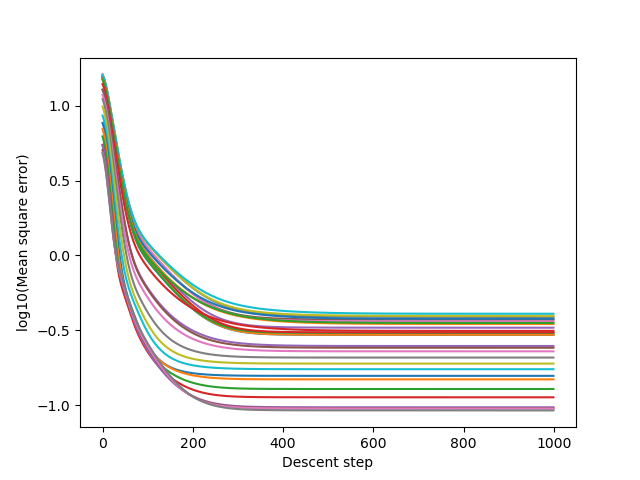

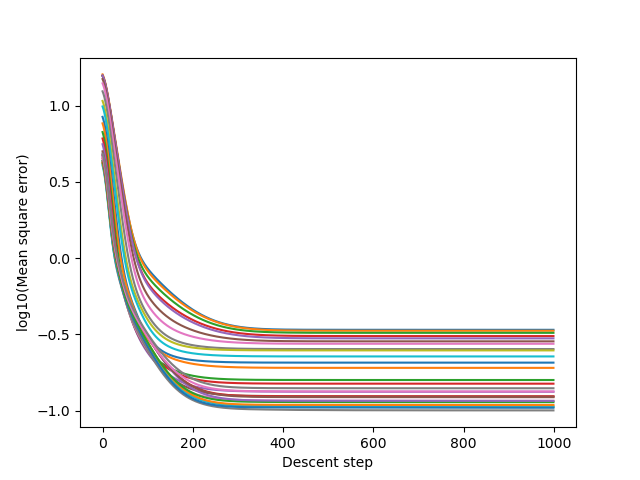

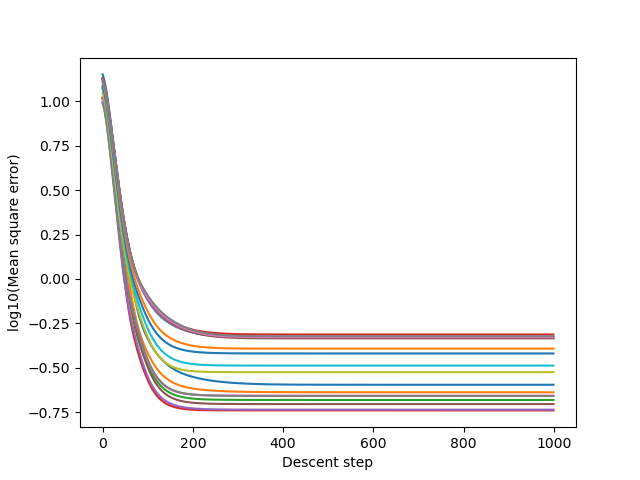

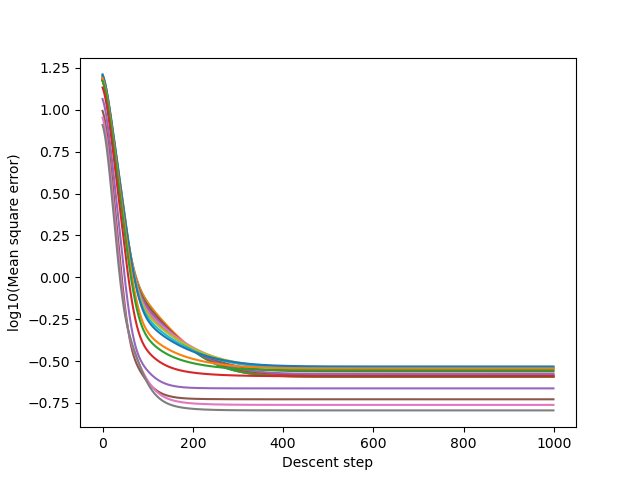

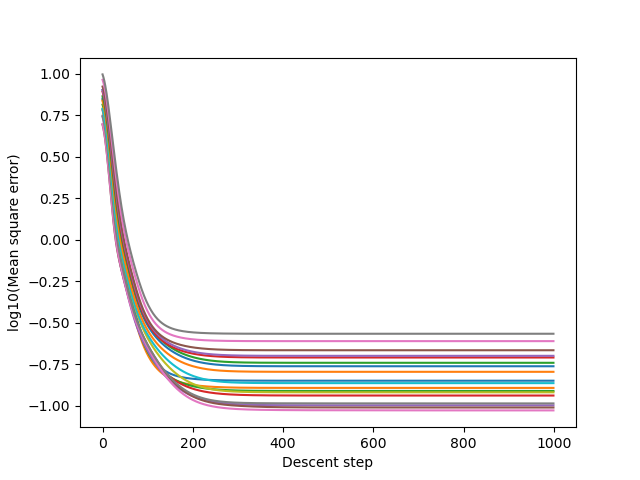

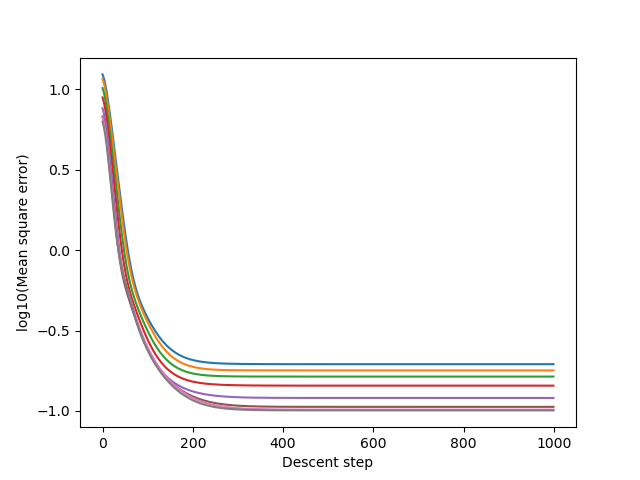

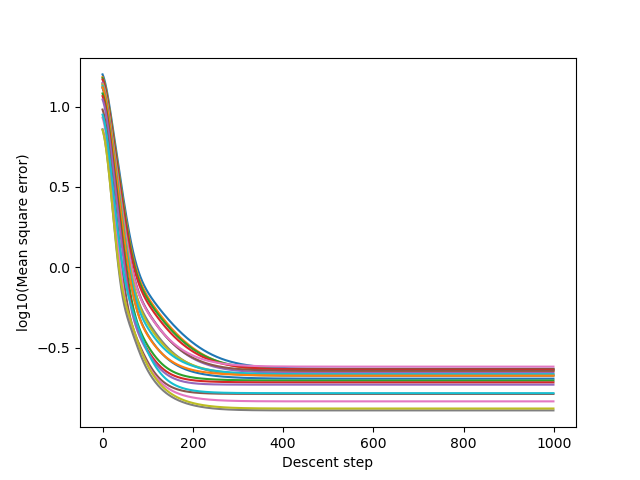

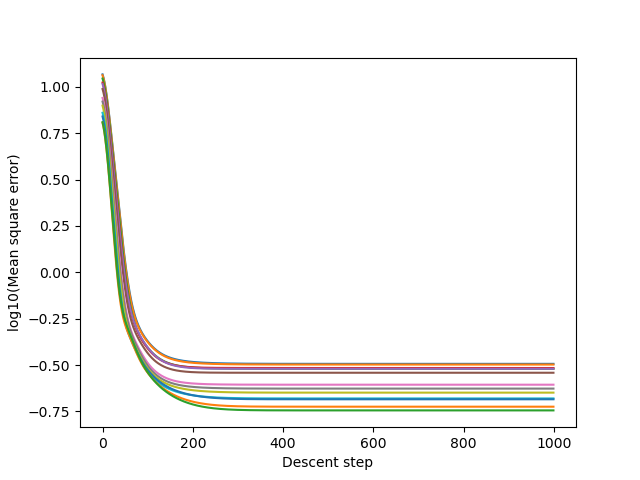

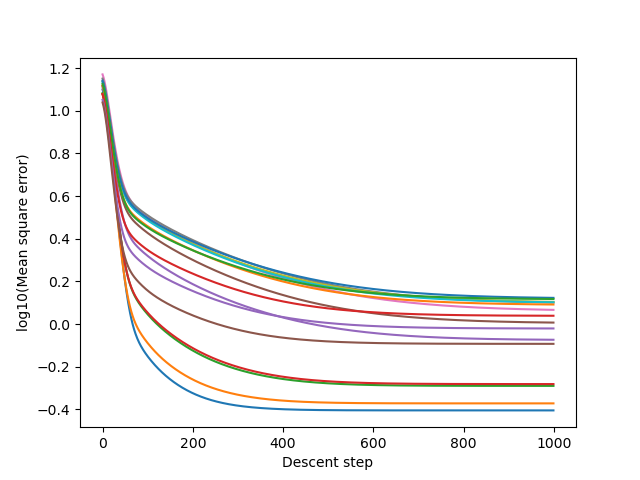

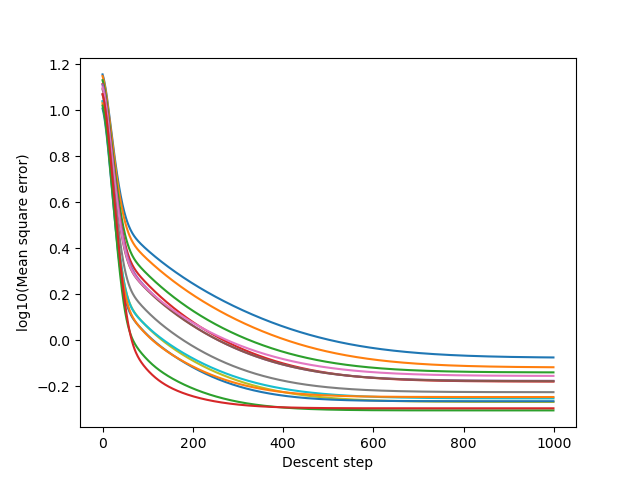

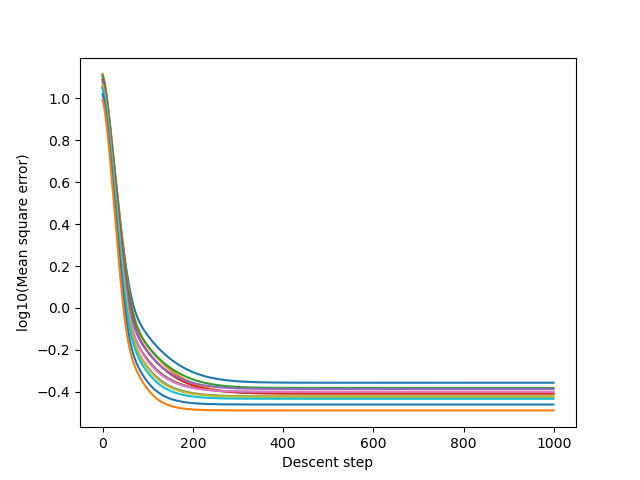

In [18]:
df = pd.read_csv('../../data/mlc4_embryos.csv')
df['Path'] = df['Path'].apply(lambda x: raw_data_path + x)
results = []
for index, row in df.iterrows():
    # print(row.Path)
    # print(row.EmbryoID)
    
    # Import movie
    img = load_image(row.Path + '/af_corrected.tif')
    roi = [np.loadtxt(row.Path + '/ROI_fit_%s.txt' % i) for i in range(img.shape[0])]
    
    # Run quantification
    iq = ImageQuant2(img=img, roi=roi, cytbg=cytbg, membg=membg)
    iq.quantify(descent_steps=1000)
    iq.plot_losses(log=True)
    
    # Compile results
    res = iq.compile_res(extra_columns={'Frame': np.arange(iq.nimgs)})
    res['EmbryoID'] = row.EmbryoID
    res['Membrane signal'] *= calibration_factor
    res = res.astype({'Frame': int})
    results.append(res)

### Combine dataframes

In [19]:
results_full = pd.concat(results)
results_full.to_csv('../../data/mlc4_quantification.csv')

### Filter out polar body

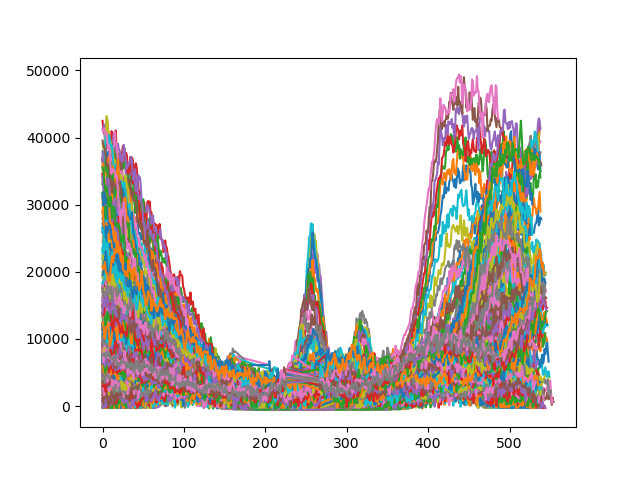

In [20]:
def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

fig, ax = plt.subplots()
results_full = pd.read_csv('../../data/mlc4_quantification.csv')
res_grouped = results_full.groupby(['EmbryoID', 'Frame'])
for i, (g, r) in enumerate(res_grouped):
    path = df[df.EmbryoID == g[0]]['Path'].values[0]
    roi = np.loadtxt(path + '/ROI_fit_%s.txt' % g[1])
    _mems = r['Membrane signal']
    mems = _mems.to_numpy()
    if os.path.exists(path + '/polar_body.txt'):
        polar_body = np.loadtxt(path + '/polar_body.txt')
        ind = int(mems.shape[0] * np.argmin(np.linalg.norm(roi - polar_body, axis=1)) / roi.shape[0])
        mems[ind-20:ind+20] = np.nan
        nans, x = nan_helper(mems)
        mems[nans] = np.interp(x(nans), x(~nans), mems[~nans])  
    ax.plot(mems)
    results_full.loc[_mems.index, 'Membrane signal'] = mems
results_full.to_csv('../../data/mlc4_quantification_no_pb.csv')